<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# LightGBM: A Highly Efficient Gradient Boosting Decision Tree
This notebook gives an example of how to train a LightGBM model to generate point forecasts of product sales in retail. We will train a LightGBM based model on the OrangeJuice dataset.

[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is an ensemble technique in which models are added to the ensemble sequentially and at each iteration a new model is trained with respect to the error of the whole ensemble learned so far. More detailed information about gradient boosting can be found in this [tutorial paper](https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full). Using this technique, LightGBM achieves great accuracy in many applications. Apart from this, it is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Due to these advantages, LightGBM has been widely-used in a lot of [winning solutions](https://github.com/microsoft/LightGBM/blob/master/examples/README.md#machine-learning-challenge-winning-solutions) of machine learning competitions.

## Global Settings and Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import random
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb

import warnings

warnings.filterwarnings("ignore")

from forecasting_lib.evaluation.evaluation_utils import MAPE
import forecasting_lib.dataset.retail.benchmark_settings as bs

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
LightGBM version: 2.3.1


## Parameter Setting

In what follows, we define global settings related to the model and feature engineering. LightGBM supports both classification models and regression models. In our case, we set the objective function to `mape` which stands for mean absolute percentage error (MAPE) since we will build a regression model to predict product sales and evaluate the accuracy of the model using MAPE.

Generally, we can adjust the number of leaves (`num_leaves`), the minimum number of data in each leaf (`min_data_in_leaf`), maximum number of boosting rounds (`num_rounds`), the learning rate of trees (`learning_rate`) and `early_stopping_rounds` (to avoid overfitting) in the model to get better performance. Besides, we can also adjust other supported parameters to optimize the results. [In this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst), a list of all the parameters is given. In addition, advice on how to tune these parameters can be found [in this url](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst).

We will use historical weekly sales, date time information, and product information as input features to train the model. Prior sales are used as lag features and `lags` contains the lags where each number indicates the number of time steps (i.e., weeks) that we shift the data backwards to get the historical sales. We also use the average sales within a certain time window in the past as a moving average feature. `window_size` controls the size of the moving window. Apart from these parameters, we use `use_columns` and `categ_fea` to denote all other features that we leverage in the model and the categorical features, respectively.


In [3]:
# Data directories
DATA_DIR = "../../contrib/tsperf/OrangeJuice_Pt_3Weeks_Weekly/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameters of LightGBM model
params = {
    "objective": "mape",
    "num_leaves": 124,
    "min_data_in_leaf": 340,
    "learning_rate": 0.1,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
    "num_rounds": 940,
    "early_stopping_rounds": 125,
    "num_threads": 16,
    "verbose_eval": 20,
    "seed": 1,
}

# Lags and categorical features
lags = np.arange(2, 20)
window_size = 40
used_columns = ["store", "brand", "week", "week_of_month", "month", "deal", "feat", "move", "price", "price_ratio"]
categ_fea = ["store", "brand", "deal"]

In [4]:
# Utility functions
from forecasting_lib.feature_engineering.feature_utils import week_of_month, df_from_cartesian_product, combine_features


def make_predictions(df, model):
    """Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({"move": model.predict(df.drop("move", axis=1))})
    predictions["move"] = predictions["move"].apply(lambda x: round(x))
    return pd.concat([df[["brand", "store", "week"]].reset_index(drop=True), predictions], axis=1)


def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store == store) & (results.brand == brand)]
    subset = subset[["week", "move", "actual"]].set_index("week")
    ax = subset.plot()
    ax.set_title("Forecast result of brand {} at store {}".format(brand, store))
    ax.set_ylabel("unit sales")
    ax.set_ylim(bottom=0)
    ax.legend(labels=["predicted", "actual"])

We assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known.

In [5]:
# Train and predict for all forecast rounds

r = 0
# Load training data
train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_round_" + str(r + 1) + ".csv"))
train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
print(train_df.head(3))
print("")
train_df = train_df[["store", "brand", "week", "move"]]

# Create a dataframe to hold all necessary data
store_list = train_df["store"].unique()
brand_list = train_df["brand"].unique()
week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r] + 1)
d = {"store": store_list, "brand": brand_list, "week": week_list}
data_grid = df_from_cartesian_product(d)
data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

# Get future price, deal, and advertisement info
aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "aux_round_" + str(r + 1) + ".csv"))
data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])

# Create relative price feature
price_cols = [
    "price1",
    "price2",
    "price3",
    "price4",
    "price5",
    "price6",
    "price7",
    "price8",
    "price9",
    "price10",
    "price11",
]
data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
data_filled.drop(price_cols, axis=1, inplace=True)

# Fill missing values
print("Number of missing rows is {}".format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
print("")
data_filled = data_filled.groupby(["store", "brand"]).apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))

# Create datetime features
data_filled["week_start"] = data_filled["week"].apply(
    lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
)
data_filled["year"] = data_filled["week_start"].apply(lambda x: x.year)
data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
data_filled.drop("week_start", axis=1, inplace=True)

# Create other features (lagged features, moving averages, etc.)
features = data_filled.groupby(["store", "brand"]).apply(
    lambda x: combine_features(x, ["move"], lags, window_size, used_columns)
)
train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
print("Maximum training week number is {}".format(max(train_fea["week"])))
print("")

# Drop rows with NaN values
train_fea.dropna(inplace=True)
print(train_fea.head(1))
print("")

store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6204

Maximum training week number is 135

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   

  

In [6]:
print("Training and predicting models...")
# Create training set
dtrain = lgb.Dataset(train_fea.drop("move", axis=1, inplace=False), label=train_fea["move"])
if r % 3 == 0:
    # Train GBM model
    print("Training model...")
    bst = lgb.train(params, dtrain, valid_sets=[dtrain], categorical_feature=categ_fea, verbose_eval=False)

# Generate forecasts
test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
pred = make_predictions(test_fea, bst).sort_values(by=["store", "brand", "week"]).reset_index(drop=True)
# Additional columns required by the submission format
pred["round"] = r + 1
pred["weeks_ahead"] = pred["week"] - bs.TRAIN_END_WEEK_LIST[r]
print(pred)
print("")

# Evaluate prediction accuracy
test_df = pd.read_csv(os.path.join(TEST_DIR, "test_round_" + str(r + 1) + ".csv"))
test_df["actual"] = test_df["logmove"].apply(lambda x: round(math.exp(x)))
test_df.drop("logmove", axis=1, inplace=True)
combined = pd.merge(pred, test_df, on=["store", "brand", "week"], how="left")
metric_value = MAPE(combined["move"], combined["actual"]) * 100
print("")
print("MAPE of current round is {}".format(metric_value))
print("")

Training and predicting models...
Training model...
      brand  store  week   move  round  weeks_ahead
0         1      2   137   9151      1            2
1         1      2   138  24055      1            3
2         2      2   137   4879      1            2
3         2      2   138  12035      1            3
4         3      2   137   2156      1            2
...     ...    ...   ...    ...    ...          ...
1821      9    137   138    459      1            3
1822     10    137   137  14673      1            2
1823     10    137   138   7523      1            3
1824     11    137   137   6825      1            2
1825     11    137   138   6676      1            3

[1826 rows x 6 columns]


MAPE of current round is 35.58242942761259



Plot feature importances...


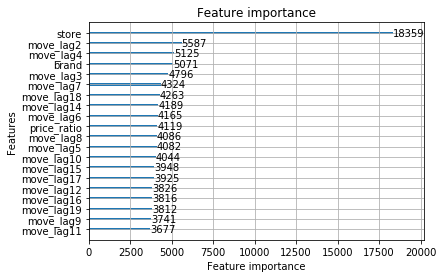

In [7]:
import matplotlib.pyplot as plt

print("Plot feature importances...")
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

Sample MAPE is 7.127405622044917
Sample MAPE is 22.28422619047619
Sample MAPE is 18.02978515625
Sample MAPE is 50.84982967283172
Sample MAPE is 11.765703914141415


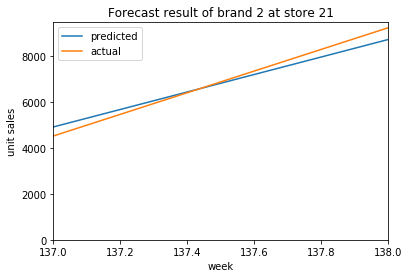

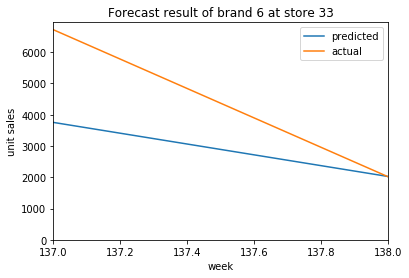

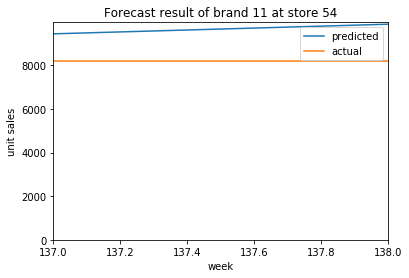

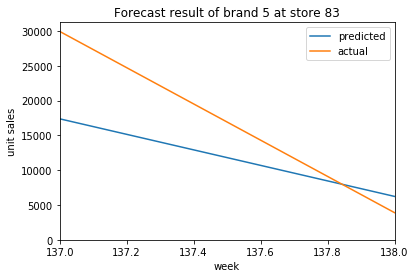

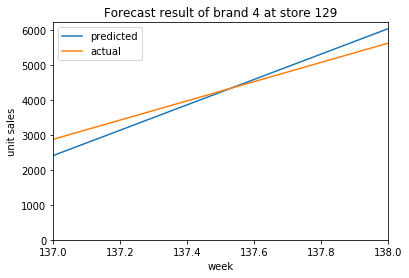

In [8]:
# Visualize forecast results
results = pd.concat([combined], axis=0)
random.seed(2)
for _ in range(5):
    store = random.choice(results["store"].unique())
    brand = random.choice(results["brand"].unique())
    plot_result(results, store, brand)

## Additional Reading

\[1\] Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. LightGBM: A highly efficient gradient boosting decision tree. In Advances in Neural Information Processing Systems. 3146–3154.<br>
\[2\] Alexey Natekin and Alois Knoll. 2013. Gradient boosting machines, a tutorial. Frontiers in neurorobotics, 7 (21). <br>
\[3\] The parameters of LightGBM: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst <br>
\[4\] Anna Veronika Dorogush, Vasily Ershov, and Andrey Gulin. 2018. CatBoost: gradient boosting with categorical features support. arXiv preprint arXiv:1810.11363 (2018).<br>
\[5\] Scikit-learn. 2018. categorical_encoding. https://github.com/scikit-learn-contrib/categorical-encoding<br>

